In [1]:
# MUST be the first cell in the notebook
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from utils import train_model, evaluate_model
import torch.optim as optim
import sys
from utils import load_it_data, visualize_img, compute_ev_and_corr
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [2]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [3]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


In [5]:
class ITNeuralActivity(Dataset):
    def __init__(self, X, y=None, transform=None):
        """
        Custom Dataset for IT neural activity prediction.

        Args:
            X (numpy array): Input stimuli (e.g., images).
            y (numpy array, optional): Neural activity (e.g., spikes). Default is None for test data.
            transform (callable, optional): Optional transform to be applied on the input stimuli.
        """
        self.X = X
        self.y = torch.from_numpy(y).float() if y is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        neural_activity = self.y[idx] if self.y is not None else None

        if self.transform:
            img = self.transform(torch.from_numpy(img).float())

        return (img, neural_activity) if neural_activity is not None else img


In [6]:
# Define the transform
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with the transform
val_dataset_res = ITNeuralActivity(stimulus_val, spikes_val, transform=transform)

# Create dataloaders
val_dataloader_res = DataLoader(val_dataset_res, batch_size=32, shuffle=False)

In [ ]:
from timm import create_model
# Load the pre-trained EfficientNet-B5 model
eff_res = create_model('efficientnet_b5', pretrained=True)
# Replace the final classifier layer to output 168 neurons
eff_res.classifier = nn.Linear(eff_res.classifier.in_features, 168)

In [ ]:
# Load the pre-trained model
model_path = './models/efficientnet_b5.pth'  # Path to the pre-trained model
if os.path.exists(model_path):
    eff_res.load_state_dict(torch.load(model_path))
    print(f"Model loaded from {model_path}.")
else:
    print(f"Model file not found at {model_path}. Please check the path.")

# Set the model to evaluation mode
eff_res.eval()

Model loaded from ./models/efficientnet_b5.pth.


[Current Model] Overall explained variance: 0.4699
[Current Model] Overall correlation: 0.6742


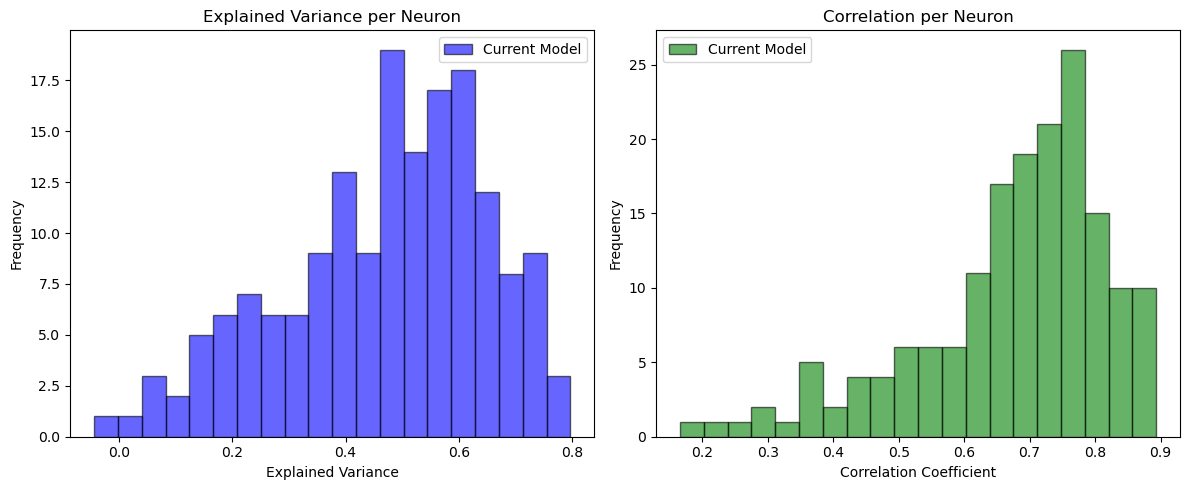

In [10]:
from utils import evaluate_model
# Evaluate the model on the validation set
evaluate_model(eff_res, val_dataloader_res, spikes_val, device="cpu")